###  PyTorch Based Classifier (CNN)

### 1. Import Essential Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import shutil 
import random
import numpy as np 
from tqdm import tqdm 
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Imported libraries")

Imported libraries


## 2. Data  preparation

In [2]:
dataset_path = r"C:\MscR\Philippines(GEDI_Resampled)\_combined"
print(f"Dataset path: {dataset_path}")

Dataset path: C:\MscR\Philippines(GEDI_Resampled)\_combined


### 3. Model Hyperparameters

In [3]:
img_size = 64
batch_size = 128
lr = 0.001
epochs = 2 
model_name = r"C:\Users\ro22332\OneDrive - University of Bristol\MscR\VS Code\GitHub\AlphaEarth-Biomass\RGB CNN\cnn_pytorch_state_dict.pth"
num_classes = 9 #

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used is {device}")

Device used is cuda


### 4. Data Augmentation and Training and Validation Data Generator

In [4]:
train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.RandomRotation(40),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
val_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])


full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

In [5]:
# Dataset split: Train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

In [6]:
#Create dataLoader
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                         )

val_loader = DataLoader(val_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                         )

### 5 Defining the model


- **`model = nn.Sequential(...)`**: A sequential container is used to build the model as a linear stack of layers. This is a convenient way to define a straightforward CNN.
  - **Convolutional Blocks**: The model consists of several blocks, each containing
      - a `Conv2d` layer for feature extraction,
      - a `ReLU` activation function,
      - a `MaxPool2d` layer to downsample and reduce dimensionality,
      - a`BatchNorm2d` to stabilize and accelerate training.    
  - **Classifier**: After the convolutional blocks,
      - `AdaptiveAvgPool2d` reduces each feature map to a single value, making the model more robust to input size variations.
      - `Flatten` converts the 2D feature maps into a 1D vector.
      - `Linear` (fully connected) layers then perform the final classification,
      - `Dropout` is used as a regularization technique to prevent overfitting.
  - **`.to(device)`**: This moves the model's parameters and buffers to the selected device (GPU, if available otherwise CPU).


In [7]:
model = nn.Sequential(
                        # Conv Block 1
                        nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(),
                        nn.MaxPool2d(2), nn.BatchNorm2d(32),
                        
                        # Conv Block 2-6
                        nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
                        nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
                        nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
                        nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
                        nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
                        
                        # Classifier
                        nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                        nn.Linear(1024, 2048), nn.ReLU(), nn.BatchNorm1d(2048), nn.Dropout(0.4),
                        nn.Linear(2048, num_classes)
                    ).to(device)

## 6. Training and validation

#### 6.1 Defining the training setup

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
best_loss = float('inf')
loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

6.2 Model Traning and Evaluation

In [9]:
print(f"Training on : ==={device}=== with batch size: {batch_size} & lr: {lr}")

# --- TRAINING LOOP ---
for epoch in range(epochs):
    # Training Phase
    start_time = time.time() # to get the training time for each epoch
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0  # for the training metrics
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        images, labels = images.to(device), labels.to(device)  # labels as integer class indices
        optimizer.zero_grad()
        outputs = model(images)  # outputs are raw logits
        loss = criterion(outputs, labels)  # criterion is nn.CrossEntropyLoss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
  
    # Synchronize CUDA before stopping timer (if using GPU)
    if device == 'cuda':
        torch.cuda.synchronize()

    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0 #  for the validation metrics
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
  
    # Save the best model
    avg_val_loss = val_loss/len(val_loader)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), model_name)
    
    # Store metrics
    loss_history['train'].append(train_loss/len(train_loader))
    loss_history['val'].append(val_loss/len(val_loader))
    acc_history['train'].append(train_correct/train_total)
    acc_history['val'].append(val_correct/val_total)
    
    #print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {loss_history['train'][-1]:.4f} | Val Loss: {loss_history['val'][-1]:.4f}")
    print(f"Train Acc: {acc_history['train'][-1]:.4f} | Val Acc: {acc_history['val'][-1]:.4f}")
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} training completed in {epoch_time:.2f} seconds\n") 

print("Trained Model. Now evaluating the model...")

Training on : ===cuda=== with batch size: 128 & lr: 0.001


Epoch 1/2: 100%|██████████| 4043/4043 [05:48<00:00, 11.61it/s]


Train Loss: 1.9408 | Val Loss: 2.0398
Train Acc: 0.2768 | Val Acc: 0.2982
Epoch 1 training completed in 411.14 seconds



Epoch 2/2: 100%|██████████| 4043/4043 [06:30<00:00, 10.34it/s]


Train Loss: 1.9108 | Val Loss: 2.1354
Train Acc: 0.2875 | Val Acc: 0.2869
Epoch 2 training completed in 447.80 seconds

Trained Model. Now evaluating the model...


### 7. Visualizing training history

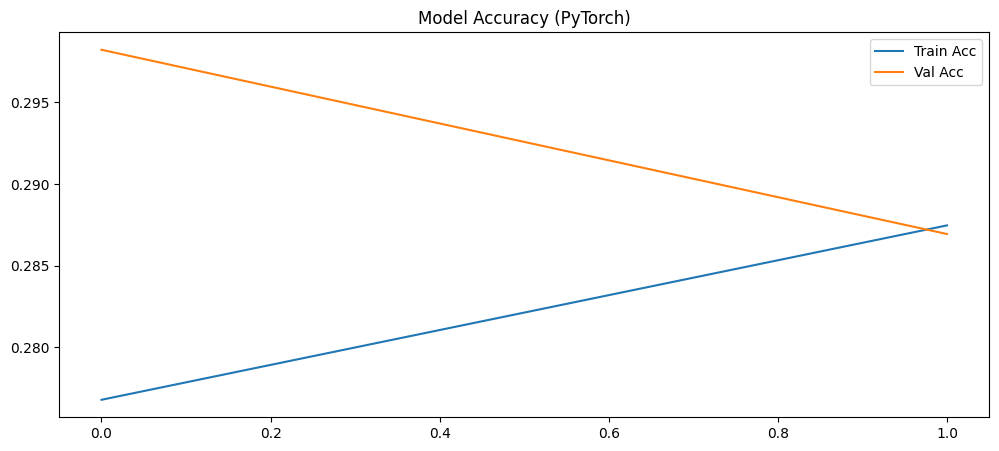

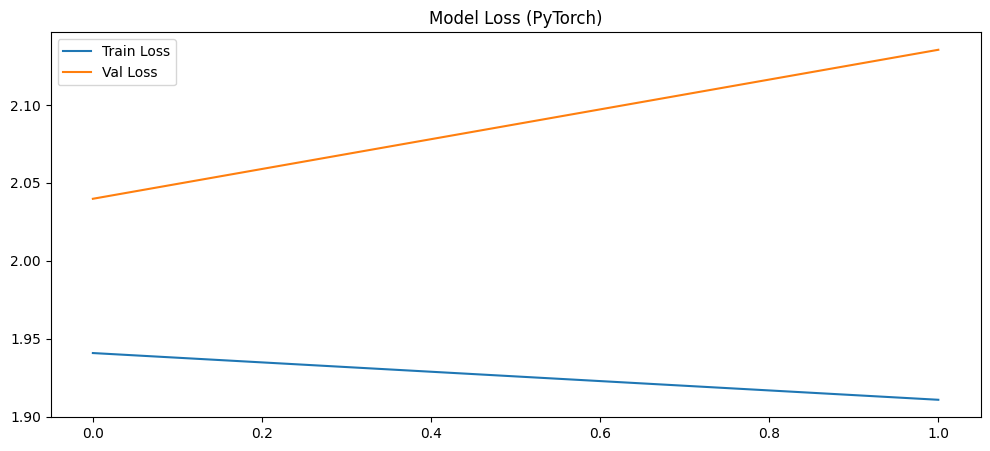

In [10]:
# Plot the Model Accuracy
plt.figure(figsize=(12, 5))
plt.plot(acc_history['train'], label='Train Acc')
plt.plot(acc_history['val'], label='Val Acc')
plt.title('Model Accuracy (PyTorch)')
plt.legend()
plt.show()

#Plot the Model Loss
plt.figure(figsize=(12, 5))
plt.plot(loss_history['train'], label='Train Loss')
plt.plot(loss_history['val'], label='Val Loss')
plt.title('Model Loss (PyTorch)')
plt.legend()
plt.show()

### 8. Model evaluation

In [12]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.numpy())


#Accuracy score 
accuracy = accuracy_score(all_labels, all_preds)
print(f"The accuracy of the model is: {accuracy:.4f}")

The accuracy of the model is: 0.2869
